In [ ]:
import json
import logging
import os
import random
import re
from pathlib import Path

import evaluate
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, BertTokenizerFast, pipeline

from src.eval_lstm import evaluate_rouge
from src.configs import CONFIG, DATA_PATH, PROJECT_PATH, ROUGE
from src.next_token_dataset import LMTextDataset, collate_fn
from src.lstm_model import LSTMLanguageModel
from src.lstm_train import train_model
from src.utils.utils import load_tweets, process_tweets_dataset, split_data

s:\yandex\text-autocomplete\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
logging.basicConfig(level=logging.INFO)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, torch.__version__

(device(type='cuda'), '2.5.1+cu124')

In [4]:
random.seed(42)
torch.manual_seed(42)

In [5]:
# –ó–∞–≥—Ä—É–∂–∞–µ–º —Ç–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [6]:
# –ó–∞–≥—Ä—É–∂–∞–µ–º –∏ –æ–±—Ä–∞–±–∞—Ç—ã–≤–∞–µ–º —Ç–≤–∏—Ç—ã
processed_texts = process_tweets_dataset(
    tokenizer=tokenizer
)

INFO:src.utils.utils:–ó–∞–≥—Ä—É–∂–∞–µ–º –æ–±—Ä–∞–±–æ—Ç–∞–Ω–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ –∏–∑ s:\yandex\text-autocomplete\data\processed_tweets.json


In [7]:
print(processed_texts[0])

['user', 'ur', '##l', 'aw', '##w', '##w', ',', 'that', "'", 's', 'a', 'bum', '##mer', '.', 'you', 'should', '##a', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', '.', ';', 'd']


In [8]:
train_texts, val_texts, test_texts = split_data(
    processed_texts
)

INFO:src.utils.utils:–ó–∞–≥—Ä—É–∂–∞–µ–º —Ä–∞–∑–¥–µ–ª–µ–Ω–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ –∏–∑ —Ñ–∞–π–ª–æ–≤
INFO:src.utils.utils:–ó–∞–≥—Ä—É–∂–µ–Ω–æ: train=1280398, val=160050, test=160050


In [9]:
pad_token_id = tokenizer.pad_token_id or 0  # –µ—Å–ª–∏ —É —Ç–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä–∞ –Ω–µ—Ç pad_token, —Ç–æ –∏—Å–ø–æ–ª—å–∑—É–µ–º 0

In [10]:
train_dataset = LMTextDataset(train_texts, tokenizer)
val_dataset   = LMTextDataset(val_texts, tokenizer)
test_dataset  = LMTextDataset(test_texts, tokenizer)

batch_size = CONFIG['training']['batch_size']

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda b: collate_fn(b, pad_token_id))

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=lambda b: collate_fn(b, pad_token_id))
    
test_loader  = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=lambda b: collate_fn(b, pad_token_id))

–®–∞–≥ 2

–®–∞–≥ 3

–ò—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ

In [11]:
vocab_size = tokenizer.vocab_size

Epoch 1/2: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40013/40013 [16:20<00:00, 40.81it/s]  
INFO:absl:Using default tokenizer.
INFO:src.lstm_train:Epoch 1: Train Loss=5.4271, Val Loss=4.8823, Val ROUGE-L=0.0294
INFO:src.lstm_train:–°–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–æ–≤–∞—è –ª—É—á—à–∞—è –º–æ–¥–µ–ª—å (ROUGE-L=0.0294)
INFO:src.lstm_train:–°–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –º–æ–¥–µ–ª—å —ç–ø–æ—Ö–∏ 1
Epoch 2/2: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 40013/40013 [18:28<00:00, 36.11it/s]  
INFO:absl:Using default tokenizer.
INFO:src.lstm_train:Epoch 2: Train Loss=4.7885, Val Loss=4.6680, Val ROUGE-L=0.0294
INFO:src.lstm_train:–°–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–æ–≤–∞—è –ª—É—á—à–∞—è –º–æ–¥–µ–ª—å (ROUGE-L=0.0294)
INFO:src.lstm_train:–°–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –º–æ–¥–µ–ª—å —ç–ø–æ—Ö–∏ 2
INFO:src.lstm_train:–û–±—É—á–µ–Ω–∏–µ –∑–∞–≤–µ—Ä—à–µ–Ω–æ. –õ—É—á—à–∏–π ROUGE-L=0.0294
INFO:src.lstm_train:–õ—É—á—à–∞—è –º–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –≤ s:\yandex\text-autocomplete\models\best_model.pt


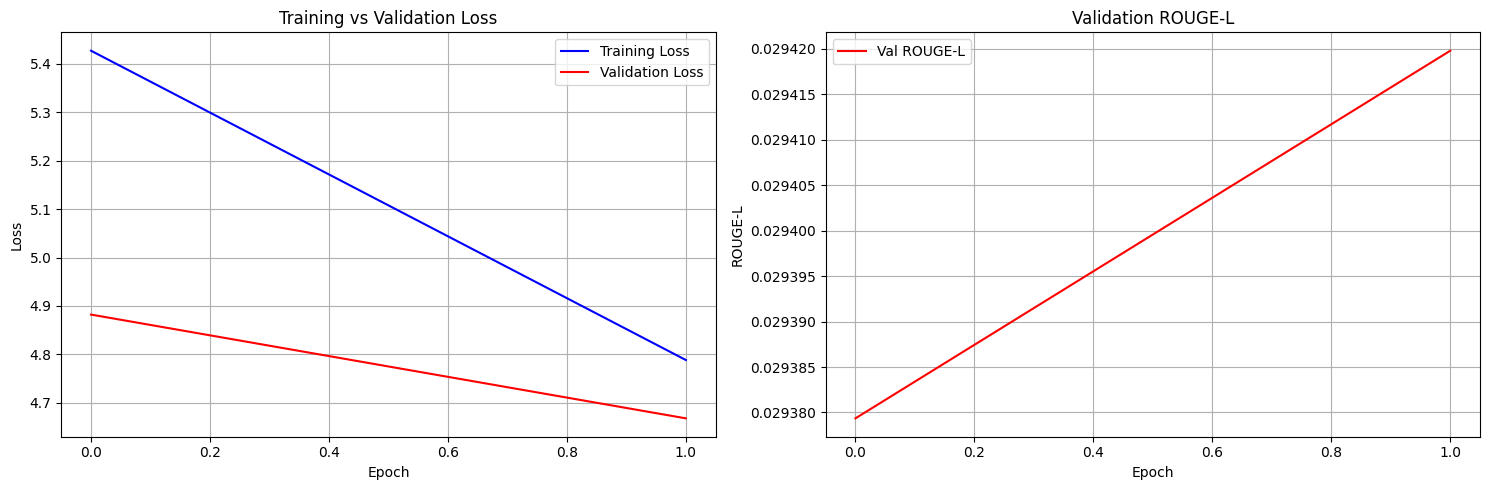

–ì–µ–Ω–µ—Ä–∞—Ü–∏—è –ø—Ä–∏–º–µ—Ä–∞...
Generated: i am feeling now. i am still in bed in my room


C:\Users\gavri\AppData\Local\Temp\ipykernel_32824\1260025172.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_path))


In [13]:

embed_dim = CONFIG['model']['embed_dim']
hidden_dim = CONFIG['model']['hidden_dim']
num_layers = CONFIG['model']['num_layers']

model = LSTMLanguageModel(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    pad_token_id=pad_token_id
)

trained_model, best_path = train_model(
    model, train_loader, val_loader, tokenizer, device,
    epochs=CONFIG['training']['epochs'],
    lr=CONFIG['training']['lr'],
    weight_decay=CONFIG['training']['weight_decay'],
    pad_token_id=pad_token_id
)

# –ó–∞–≥—Ä—É–∂–∞–µ–º –ª—É—á—à–∏–π —á–µ–∫–ø–æ–π–Ω—Ç
best_model = LSTMLanguageModel(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    pad_token_id=pad_token_id
).to(device)
best_model.load_state_dict(torch.load(best_path))

# –ì–µ–Ω–µ—Ä–∞—Ü–∏—è –ø—Ä–∏–º–µ—Ä–∞
print("–ì–µ–Ω–µ—Ä–∞—Ü–∏—è –ø—Ä–∏–º–µ—Ä–∞...")
sample_text = "i am feeling"
input_ids = tokenizer.encode(sample_text, return_tensors="pt").to(device)
print("Generated:", best_model.generate(input_ids, tokenizer, max_new_tokens=10, top_k=20))


In [10]:
# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –ø—Ä–µ–¥–æ–±—É—á–µ–Ω–Ω–æ–π –º–æ–¥–µ–ª–∏ distilgpt2
print("–ó–∞–≥—Ä—É–∑–∫–∞ –ø—Ä–µ–¥–æ–±—É—á–µ–Ω–Ω–æ–π –º–æ–¥–µ–ª–∏ distilgpt2...")
generator = pipeline("text-generation", model="distilgpt2", device=0 if torch.cuda.is_available() else -1)
distil_tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
distil_model = AutoModelForCausalLM.from_pretrained("distilgpt2")

# –î–æ–±–∞–≤–ª—è–µ–º pad_token –µ—Å–ª–∏ –µ–≥–æ –Ω–µ—Ç
if distil_tokenizer.pad_token is None:
    distil_tokenizer.pad_token = distil_tokenizer.eos_token

print("–ú–æ–¥–µ–ª—å –∑–∞–≥—Ä—É–∂–µ–Ω–∞ —É—Å–ø–µ—à–Ω–æ!")

–ó–∞–≥—Ä—É–∑–∫–∞ –ø—Ä–µ–¥–æ–±—É—á–µ–Ω–Ω–æ–π –º–æ–¥–µ–ª–∏ distilgpt2...


Device set to use cuda:0


–ú–æ–¥–µ–ª—å –∑–∞–≥—Ä—É–∂–µ–Ω–∞ —É—Å–ø–µ—à–Ω–æ!


In [43]:
def generate_with_distilgpt2(text, max_new_tokens=20, do_sample=True, top_k=50, top_p=0.95, temperature=1.0):
    """
    –ì–µ–Ω–µ—Ä–∞—Ü–∏—è —Ç–µ–∫—Å—Ç–∞ —Å –ø–æ–º–æ—â—å—é distilgpt2.
    
    Args:
        text (str): –í—Ö–æ–¥–Ω–æ–π –∫–æ–Ω—Ç–µ–∫—Å—Ç.
        max_new_tokens (int): –ú–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–æ–≤—ã—Ö —Ç–æ–∫–µ–Ω–æ–≤ –¥–ª—è –≥–µ–Ω–µ—Ä–∞—Ü–∏–∏.
        do_sample (bool): –ò—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –ª–∏ —Å—ç–º–ø–ª–∏—Ä–æ–≤–∞–Ω–∏–µ.
        top_k (int): –ü–∞—Ä–∞–º–µ—Ç—Ä top-k —Å—ç–º–ø–ª–∏—Ä–æ–≤–∞–Ω–∏—è.
        top_p (float): –ü–∞—Ä–∞–º–µ—Ç—Ä top-p (nucleus) —Å—ç–º–ø–ª–∏—Ä–æ–≤–∞–Ω–∏—è.
        temperature (float): –¢–µ–º–ø–µ—Ä–∞—Ç—É—Ä–∞ —Å—ç–º–ø–ª–∏—Ä–æ–≤–∞–Ω–∏—è.
        
    Returns:
        str: –°–≥–µ–Ω–µ—Ä–∏—Ä–æ–≤–∞–Ω–Ω—ã–π —Ç–µ–∫—Å—Ç.
    """
    # –ü–æ–¥–≥–æ—Ç–∞–≤–ª–∏–≤–∞–µ–º –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –≥–µ–Ω–µ—Ä–∞—Ü–∏–∏
    generation_kwargs = {
        "max_new_tokens": max_new_tokens,
        "do_sample": do_sample,
        "temperature": temperature,
        "pad_token_id": distil_tokenizer.eos_token_id,
        "truncation": True
    }
    
    # –î–æ–±–∞–≤–ª—è–µ–º –ø–∞—Ä–∞–º–µ—Ç—Ä—ã —Å—ç–º–ø–ª–∏—Ä–æ–≤–∞–Ω–∏—è —Ç–æ–ª—å–∫–æ –µ—Å–ª–∏ –∏—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è —Å—ç–º–ø–ª–∏—Ä–æ–≤–∞–Ω–∏–µ
    if do_sample:
        generation_kwargs.update({
            "top_k": top_k,
            "top_p": top_p
        })
    
    result = generator(text, **generation_kwargs)
    return result[0]["generated_text"]

In [23]:
def evaluate_distilgpt2_rouge(val_texts, max_samples=2000, max_new_tokens=20, 
                              do_sample=True, top_k=50, top_p=0.95, temperature=1.0):
    """
    –û—Ü–µ–Ω–∫–∞ –∫–∞—á–µ—Å—Ç–≤–∞ distilgpt2 —Å –ø–æ–º–æ—â—å—é –º–µ—Ç—Ä–∏–∫–∏ ROUGE.
    
    Args:
        val_texts (list): –°–ø–∏—Å–æ–∫ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω—ã—Ö —Ç–µ–∫—Å—Ç–æ–≤ (–∏—Å—Ö–æ–¥–Ω—ã–µ —Å—Ç—Ä–æ–∫–∏).
        max_samples (int): –ú–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–º–µ—Ä–æ–≤ –¥–ª—è –æ—Ü–µ–Ω–∫–∏.
        max_new_tokens (int): –ú–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–æ–≤—ã—Ö —Ç–æ–∫–µ–Ω–æ–≤ –¥–ª—è –≥–µ–Ω–µ—Ä–∞—Ü–∏–∏.
        do_sample (bool): –ò—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –ª–∏ —Å—ç–º–ø–ª–∏—Ä–æ–≤–∞–Ω–∏–µ.
        top_k (int): –ü–∞—Ä–∞–º–µ—Ç—Ä top-k —Å—ç–º–ø–ª–∏—Ä–æ–≤–∞–Ω–∏—è.
        top_p (float): –ü–∞—Ä–∞–º–µ—Ç—Ä top-p —Å—ç–º–ø–ª–∏—Ä–æ–≤–∞–Ω–∏—è.
        temperature (float): –¢–µ–º–ø–µ—Ä–∞—Ç—É—Ä–∞ —Å—ç–º–ø–ª–∏—Ä–æ–≤–∞–Ω–∏—è.
        
    Returns:
        dict: –°–ª–æ–≤–∞—Ä—å —Å –º–µ—Ç—Ä–∏–∫–∞–º–∏ ROUGE.
    """
    preds, refs = [], []
    processed = 0
    
    print(f"–û—Ü–µ–Ω–∫–∞ distilgpt2 –Ω–∞ {min(len(val_texts), max_samples)} –ø—Ä–∏–º–µ—Ä–∞—Ö...")
    
    for i, text in enumerate(tqdm(val_texts[:max_samples])):
        if processed >= max_samples:
            break
            
        # –ü—Ä–æ–≤–µ—Ä—è–µ–º, —á—Ç–æ text - —ç—Ç–æ —Å—Ç—Ä–æ–∫–∞, –∞ –Ω–µ —Å–ø–∏—Å–æ–∫ —Ç–æ–∫–µ–Ω–æ–≤
        if isinstance(text, list):
            # –ï—Å–ª–∏ —ç—Ç–æ —Å–ø–∏—Å–æ–∫ —Ç–æ–∫–µ–Ω–æ–≤, –ø—Ä–æ–ø—É—Å–∫–∞–µ–º —ç—Ç–æ—Ç –ø—Ä–∏–º–µ—Ä
            continue
            
        # –ü—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∞ —Ç–µ–∫—Å—Ç–∞ - –ø–æ–ª—É—á–∞–µ–º —Å—Ç—Ä–æ–∫—É, –∞ –Ω–µ —Ç–æ–∫–µ–Ω—ã
        processed_text = preprocess_text(text, tokenizer=None)  # –ù–µ –∏—Å–ø–æ–ª—å–∑—É–µ–º —Ç–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä
        
        # –¢–µ–ø–µ—Ä—å —Ç–æ–∫–µ–Ω–∏–∑–∏—Ä—É–µ–º —Å –ø–æ–º–æ—â—å—é distil_tokenizer
        tokens = distil_tokenizer.tokenize(processed_text)
        if len(tokens) < 4:
            continue
            
        # –ë–µ—Ä–µ–º –ø–µ—Ä–≤—ã–µ 75% –∫–∞–∫ –∫–æ–Ω—Ç–µ–∫—Å—Ç
        cutoff = max(1, int(len(tokens) * 0.75))
        context_tokens = tokens[:cutoff]
        target_tokens = tokens[cutoff:]
        
        if len(target_tokens) == 0:
            continue
            
        # –î–µ–∫–æ–¥–∏—Ä—É–µ–º –∫–æ–Ω—Ç–µ–∫—Å—Ç
        context_text = distil_tokenizer.convert_tokens_to_string(context_tokens)
        target_text = distil_tokenizer.convert_tokens_to_string(target_tokens)
        
        # –ì–µ–Ω–µ—Ä–∏—Ä—É–µ–º –ø—Ä–æ–¥–æ–ª–∂–µ–Ω–∏–µ
        try:
            generated_text = generate_with_distilgpt2(
                context_text, 
                max_new_tokens=len(target_tokens) + 5,  # –ì–µ–Ω–µ—Ä–∏—Ä—É–µ–º –ø—Ä–∏–º–µ—Ä–Ω–æ —Å—Ç–æ–ª—å–∫–æ –∂–µ —Ç–æ–∫–µ–Ω–æ–≤ + –Ω–µ–±–æ–ª—å—à–æ–π –∑–∞–ø–∞—Å
                do_sample=do_sample,
                top_k=top_k,
                top_p=top_p,
                temperature=temperature
            )
            
            # –ò–∑–≤–ª–µ–∫–∞–µ–º —Ç–æ–ª—å–∫–æ —Å–≥–µ–Ω–µ—Ä–∏—Ä–æ–≤–∞–Ω–Ω—É—é —á–∞—Å—Ç—å
            generated_continuation = generated_text[len(context_text):].strip()
            
            preds.append(generated_continuation)
            refs.append(target_text)
            processed += 1
            
        except Exception as e:
            print(f"–û—à–∏–±–∫–∞ –ø—Ä–∏ –≥–µ–Ω–µ—Ä–∞—Ü–∏–∏ –¥–ª—è –ø—Ä–∏–º–µ—Ä–∞ {i}: {e}")
            continue
    
    print(f"–û–±—Ä–∞–±–æ—Ç–∞–Ω–æ {len(preds)} –ø—Ä–∏–º–µ—Ä–æ–≤")
    
    if len(preds) == 0:
        return {"rouge1": 0.0, "rouge2": 0.0, "rougeL": 0.0}
    
    # –í—ã—á–∏—Å–ª—è–µ–º ROUGE –º–µ—Ç—Ä–∏–∫–∏
    rouge_scores = rouge.compute(predictions=preds, references=refs)
    return rouge_scores

In [24]:
# –°–æ–∑–¥–∞–µ–º –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω—É—é –≤—ã–±–æ—Ä–∫—É –∏–∑ –∏—Å—Ö–æ–¥–Ω—ã—Ö —Ç–µ–∫—Å—Ç–æ–≤
print("–°–æ–∑–¥–∞–Ω–∏–µ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–∏ –∏–∑ –∏—Å—Ö–æ–¥–Ω—ã—Ö —Ç–µ–∫—Å—Ç–æ–≤...")

# –ó–∞–≥—Ä—É–∂–∞–µ–º –∏—Å—Ö–æ–¥–Ω—ã–µ —Ç–µ–∫—Å—Ç—ã
with open(r'S:\yandex\text-autocomplete\data\tweets.txt', 'r') as file:
    original_tweets = file.readlines()

# –°–æ–∑–¥–∞–µ–º —Ç–∞–∫—É—é –∂–µ —Ä–∞–∑–±–∏–≤–∫—É –∫–∞–∫ –¥–ª—è –æ–±—Ä–∞–±–æ—Ç–∞–Ω–Ω—ã—Ö —Ç–µ–∫—Å—Ç–æ–≤
train_original, temp_original = train_test_split(original_tweets, test_size=0.2, random_state=42)
val_original, test_original = train_test_split(temp_original, test_size=0.5, random_state=42)

print(f"–ò—Å—Ö–æ–¥–Ω—ã—Ö —Ç–µ–∫—Å—Ç–æ–≤: {len(original_tweets)}")
print(f"–í–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω—ã—Ö —Ç–µ–∫—Å—Ç–æ–≤: {len(val_original)}")

–°–æ–∑–¥–∞–Ω–∏–µ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–∏ –∏–∑ –∏—Å—Ö–æ–¥–Ω—ã—Ö —Ç–µ–∫—Å—Ç–æ–≤...
–ò—Å—Ö–æ–¥–Ω—ã—Ö —Ç–µ–∫—Å—Ç–æ–≤: 1600498
–í–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω—ã—Ö —Ç–µ–∫—Å—Ç–æ–≤: 160050


In [28]:
rouge = evaluate.load("rouge")
# –ü–æ–¥–±–æ—Ä –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –≥–µ–Ω–µ—Ä–∞—Ü–∏–∏ (–∏—Å–ø—Ä–∞–≤–ª–µ–Ω–Ω–∞—è –≤–µ—Ä—Å–∏—è)
print("=== –ü–æ–¥–±–æ—Ä –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –≥–µ–Ω–µ—Ä–∞—Ü–∏–∏ –¥–ª—è distilgpt2 ===")

# –ü–∞—Ä–∞–º–µ—Ç—Ä—ã –¥–ª—è —Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏—è
param_configs = [
    {"top_k": 20, "top_p": 0.9, "temperature": 0.8, "name": "–ö–æ–Ω—Å–µ—Ä–≤–∞—Ç–∏–≤–Ω–∞—è"},
    {"top_k": 50, "top_p": 0.95, "temperature": 1.0, "name": "–°—Ç–∞–Ω–¥–∞—Ä—Ç–Ω–∞—è"},
    {"top_k": 100, "top_p": 0.98, "temperature": 1.2, "name": "–ö—Ä–µ–∞—Ç–∏–≤–Ω–∞—è"},
    {"top_k": 10, "top_p": 0.8, "temperature": 0.6, "name": "–û—Å—Ç–æ—Ä–æ–∂–Ω–∞—è"},
    {"top_k": 200, "top_p": 0.99, "temperature": 1.5, "name": "–≠–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç–∞–ª—å–Ω–∞—è"}
]

def extract_rouge_score(rouge_value):
    """
    –ò–∑–≤–ª–µ–∫–∞–µ—Ç —á–∏—Å–ª–æ–≤–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ ROUGE –º–µ—Ç—Ä–∏–∫–∏.
    
    Args:
        rouge_value: –ó–Ω–∞—á–µ–Ω–∏–µ ROUGE –º–µ—Ç—Ä–∏–∫–∏ (–º–æ–∂–µ—Ç –±—ã—Ç—å –æ–±—ä–µ–∫—Ç–æ–º —Å .mid.fmeasure –∏–ª–∏ –ø—Ä–æ—Å—Ç–æ —á–∏—Å–ª–æ–º).
        
    Returns:
        float: –ß–∏—Å–ª–æ–≤–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ –º–µ—Ç—Ä–∏–∫–∏.
    """
    if hasattr(rouge_value, 'mid') and hasattr(rouge_value.mid, 'fmeasure'):
        return rouge_value.mid.fmeasure
    elif hasattr(rouge_value, 'fmeasure'):
        return rouge_value.fmeasure
    else:
        return float(rouge_value)

best_rouge = 0.0
best_config = None
results = []

for config in param_configs:
    print(f"\n–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–∏: {config['name']}")
    print(f"–ü–∞—Ä–∞–º–µ—Ç—Ä—ã: top_k={config['top_k']}, top_p={config['top_p']}, temperature={config['temperature']}")
    
    # –ò—Å–ø–æ–ª—å–∑—É–µ–º val_original
    rouge_scores = evaluate_distilgpt2_rouge(
        val_original,  # –ò—Å–ø–æ–ª—å–∑—É–µ–º –∏—Å—Ö–æ–¥–Ω—ã–µ —Ç–µ–∫—Å—Ç—ã
        max_samples=500,  # –ú–µ–Ω—å—à–µ –ø—Ä–∏–º–µ—Ä–æ–≤ –¥–ª—è –±—ã—Å—Ç—Ä–æ–≥–æ —Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏—è
        max_new_tokens=20,
        do_sample=True,
        top_k=config['top_k'],
        top_p=config['top_p'],
        temperature=config['temperature']
    )
    
    # –ò–∑–≤–ª–µ–∫–∞–µ–º ROUGE scores —Å –ø–æ–º–æ—â—å—é —É–Ω–∏–≤–µ—Ä—Å–∞–ª—å–Ω–æ–π —Ñ—É–Ω–∫—Ü–∏–∏
    rouge1 = extract_rouge_score(rouge_scores["rouge1"])
    rouge2 = extract_rouge_score(rouge_scores["rouge2"])
    rouge_l = extract_rouge_score(rouge_scores["rougeL"])
    
    results.append({
        "config": config,
        "rouge1": rouge1,
        "rouge2": rouge2,
        "rougeL": rouge_l
    })
    
    print(f"ROUGE-1: {rouge1:.4f}")
    print(f"ROUGE-2: {rouge2:.4f}")
    print(f"ROUGE-L: {rouge_l:.4f}")
    
    if rouge_l > best_rouge:
        best_rouge = rouge_l
        best_config = config

print(f"\nüèÜ –õ—É—á—à–∞—è –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è: {best_config['name']}")
print(f"–õ—É—á—à–∏–π ROUGE-L: {best_rouge:.4f}")

=== –ü–æ–¥–±–æ—Ä –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –≥–µ–Ω–µ—Ä–∞—Ü–∏–∏ –¥–ª—è distilgpt2 ===

–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–∏: –ö–æ–Ω—Å–µ—Ä–≤–∞—Ç–∏–≤–Ω–∞—è
–ü–∞—Ä–∞–º–µ—Ç—Ä—ã: top_k=20, top_p=0.9, temperature=0.8
–û—Ü–µ–Ω–∫–∞ distilgpt2 –Ω–∞ 500 –ø—Ä–∏–º–µ—Ä–∞—Ö...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:36<00:00, 13.75it/s]


–û–±—Ä–∞–±–æ—Ç–∞–Ω–æ 491 –ø—Ä–∏–º–µ—Ä–æ–≤
ROUGE-1: 0.0489
ROUGE-2: 0.0035
ROUGE-L: 0.0477

–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–∏: –°—Ç–∞–Ω–¥–∞—Ä—Ç–Ω–∞—è
–ü–∞—Ä–∞–º–µ—Ç—Ä—ã: top_k=50, top_p=0.95, temperature=1.0
–û—Ü–µ–Ω–∫–∞ distilgpt2 –Ω–∞ 500 –ø—Ä–∏–º–µ—Ä–∞—Ö...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:33<00:00, 14.89it/s]


–û–±—Ä–∞–±–æ—Ç–∞–Ω–æ 491 –ø—Ä–∏–º–µ—Ä–æ–≤
ROUGE-1: 0.0460
ROUGE-2: 0.0067
ROUGE-L: 0.0443

–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–∏: –ö—Ä–µ–∞—Ç–∏–≤–Ω–∞—è
–ü–∞—Ä–∞–º–µ—Ç—Ä—ã: top_k=100, top_p=0.98, temperature=1.2
–û—Ü–µ–Ω–∫–∞ distilgpt2 –Ω–∞ 500 –ø—Ä–∏–º–µ—Ä–∞—Ö...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:32<00:00, 15.23it/s]


–û–±—Ä–∞–±–æ—Ç–∞–Ω–æ 491 –ø—Ä–∏–º–µ—Ä–æ–≤
ROUGE-1: 0.0337
ROUGE-2: 0.0016
ROUGE-L: 0.0331

–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–∏: –û—Å—Ç–æ—Ä–æ–∂–Ω–∞—è
–ü–∞—Ä–∞–º–µ—Ç—Ä—ã: top_k=10, top_p=0.8, temperature=0.6
–û—Ü–µ–Ω–∫–∞ distilgpt2 –Ω–∞ 500 –ø—Ä–∏–º–µ—Ä–∞—Ö...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:32<00:00, 15.47it/s]


–û–±—Ä–∞–±–æ—Ç–∞–Ω–æ 491 –ø—Ä–∏–º–µ—Ä–æ–≤
ROUGE-1: 0.0615
ROUGE-2: 0.0092
ROUGE-L: 0.0603

–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–∏: –≠–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç–∞–ª—å–Ω–∞—è
–ü–∞—Ä–∞–º–µ—Ç—Ä—ã: top_k=200, top_p=0.99, temperature=1.5
–û—Ü–µ–Ω–∫–∞ distilgpt2 –Ω–∞ 500 –ø—Ä–∏–º–µ—Ä–∞—Ö...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:32<00:00, 15.28it/s]


–û–±—Ä–∞–±–æ—Ç–∞–Ω–æ 491 –ø—Ä–∏–º–µ—Ä–æ–≤
ROUGE-1: 0.0239
ROUGE-2: 0.0007
ROUGE-L: 0.0231

üèÜ –õ—É—á—à–∞—è –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è: –û—Å—Ç–æ—Ä–æ–∂–Ω–∞—è
–õ—É—á—à–∏–π ROUGE-L: 0.0603


In [29]:
# –û—Ü–µ–Ω–∫–∞ –Ω–∞ –ø–æ–ª–Ω–æ–π –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–µ —Å –ª—É—á—à–∏–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏
print(f"\n=== –§–∏–Ω–∞–ª—å–Ω–∞—è –æ—Ü–µ–Ω–∫–∞ —Å –ª—É—á—à–∏–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏ ===")
print(f"–ò—Å–ø–æ–ª—å–∑—É–µ–º –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—é: {best_config['name']}")

final_rouge_scores = evaluate_distilgpt2_rouge(
    val_original, 
    max_samples=2000,
    max_new_tokens=20,
    do_sample=True,
    top_k=best_config['top_k'],
    top_p=best_config['top_p'],
    temperature=best_config['temperature']
)

# –ò–∑–≤–ª–µ–∫–∞–µ–º —Ñ–∏–Ω–∞–ª—å–Ω—ã–µ ROUGE scores
final_rouge1 = extract_rouge_score(final_rouge_scores['rouge1'])
final_rouge2 = extract_rouge_score(final_rouge_scores['rouge2'])
final_rouge_l = extract_rouge_score(final_rouge_scores['rougeL'])

print(f"\nüìä –§–∏–Ω–∞–ª—å–Ω—ã–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã distilgpt2:")
print(f"ROUGE-1: {final_rouge1:.4f}")
print(f"ROUGE-2: {final_rouge2:.4f}")
print(f"ROUGE-L: {final_rouge_l:.4f}")


=== –§–∏–Ω–∞–ª—å–Ω–∞—è –æ—Ü–µ–Ω–∫–∞ —Å –ª—É—á—à–∏–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏ ===
–ò—Å–ø–æ–ª—å–∑—É–µ–º –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—é: –û—Å—Ç–æ—Ä–æ–∂–Ω–∞—è
–û—Ü–µ–Ω–∫–∞ distilgpt2 –Ω–∞ 2000 –ø—Ä–∏–º–µ—Ä–∞—Ö...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2000/2000 [02:13<00:00, 15.00it/s]


–û–±—Ä–∞–±–æ—Ç–∞–Ω–æ 1974 –ø—Ä–∏–º–µ—Ä–æ–≤

üìä –§–∏–Ω–∞–ª—å–Ω—ã–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã distilgpt2:
ROUGE-1: 0.0629
ROUGE-2: 0.0078
ROUGE-L: 0.0621


In [31]:
# –ü—Ä–∏–º–µ—Ä—ã –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π
print("\n=== –ü—Ä–∏–º–µ—Ä—ã –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π distilgpt2 ===")

# –í—ã–±–∏—Ä–∞–µ–º –Ω–µ—Å–∫–æ–ª—å–∫–æ –ø—Ä–∏–º–µ—Ä–æ–≤ –∏–∑ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–∏
sample_indices = [0, 10, 50, 100, 200]
sample_texts = [val_original[i] for i in sample_indices if i < len(val_original)]

for i, text in enumerate(sample_texts):
    print(f"\n--- –ü—Ä–∏–º–µ—Ä {i+1} ---")
    
    # –ü—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∞ - –ø–æ–ª—É—á–∞–µ–º —Å—Ç—Ä–æ–∫—É, –∞ –Ω–µ —Ç–æ–∫–µ–Ω—ã
    processed_text = preprocess_text(text, tokenizer=None)  # –ù–µ –∏—Å–ø–æ–ª—å–∑—É–µ–º —Ç–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä
    tokens = distil_tokenizer.tokenize(processed_text)
    
    if len(tokens) < 4:
        continue
        
    # –†–∞–∑–±–∏–≤–∞–µ–º –Ω–∞ –∫–æ–Ω—Ç–µ–∫—Å—Ç –∏ —Ü–µ–ª—å
    cutoff = max(1, int(len(tokens) * 0.75))
    context_tokens = tokens[:cutoff]
    target_tokens = tokens[cutoff:]
    
    context_text = distil_tokenizer.convert_tokens_to_string(context_tokens)
    target_text = distil_tokenizer.convert_tokens_to_string(target_tokens)
    
    print(f"–ò—Å—Ö–æ–¥–Ω—ã–π —Ç–µ–∫—Å—Ç: {text[:100]}...")
    print(f"–ö–æ–Ω—Ç–µ–∫—Å—Ç: {context_text}")
    print(f"–û–∂–∏–¥–∞–µ–º–æ–µ –ø—Ä–æ–¥–æ–ª–∂–µ–Ω–∏–µ: {target_text}")
    
    # –ì–µ–Ω–µ—Ä–∏—Ä—É–µ–º —Å –ª—É—á—à–∏–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏
    try:
        generated_text = generate_with_distilgpt2(
            context_text,
            max_new_tokens=len(target_tokens) + 5,  # –ò—Å–ø–æ–ª—å–∑—É–µ–º max_new_tokens –≤–º–µ—Å—Ç–æ max_length
            do_sample=True,
            top_k=best_config['top_k'],
            top_p=best_config['top_p'],
            temperature=best_config['temperature']
        )
        
        generated_continuation = generated_text[len(context_text):].strip()
        print(f"–°–≥–µ–Ω–µ—Ä–∏—Ä–æ–≤–∞–Ω–Ω–æ–µ –ø—Ä–æ–¥–æ–ª–∂–µ–Ω–∏–µ: {generated_continuation}")
        
    except Exception as e:
        print(f"–û—à–∏–±–∫–∞ –ø—Ä–∏ –≥–µ–Ω–µ—Ä–∞—Ü–∏–∏: {e}")


=== –ü—Ä–∏–º–µ—Ä—ã –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π distilgpt2 ===

--- –ü—Ä–∏–º–µ—Ä 1 ---
–ò—Å—Ö–æ–¥–Ω—ã–π —Ç–µ–∫—Å—Ç: @mgatton nice hair cut!  dude why were your students leaving in the middle of class, 1st period?
...
–ö–æ–Ω—Ç–µ–∫—Å—Ç: <user> nice hair cut! dude why were your students leaving in the middle of
–û–∂–∏–¥–∞–µ–º–æ–µ –ø—Ä–æ–¥–æ–ª–∂–µ–Ω–∏–µ:  class, 1st period?
–°–≥–µ–Ω–µ—Ä–∏—Ä–æ–≤–∞–Ω–Ω–æ–µ –ø—Ä–æ–¥–æ–ª–∂–µ–Ω–∏–µ: the night?

--- –ü—Ä–∏–º–µ—Ä 2 ---
–ò—Å—Ö–æ–¥–Ω—ã–π —Ç–µ–∫—Å—Ç: Just packed my stethoscope 
...
–ö–æ–Ω—Ç–µ–∫—Å—Ç: just packed my st
–û–∂–∏–¥–∞–µ–º–æ–µ –ø—Ä–æ–¥–æ–ª–∂–µ–Ω–∏–µ: ethoscope
–°–≥–µ–Ω–µ—Ä–∏—Ä–æ–≤–∞–Ω–Ω–æ–µ –ø—Ä–æ–¥–æ–ª–∂–µ–Ω–∏–µ: roller with a bunch of friends and

--- –ü—Ä–∏–º–µ—Ä 3 ---
–ò—Å—Ö–æ–¥–Ω—ã–π —Ç–µ–∫—Å—Ç: I couldn't go to the Revlon Run Walk today because my formerly broken ankle is throbbing.  
...
–ö–æ–Ω—Ç–µ–∫—Å—Ç: i couldn't go to the revlon run walk today because my formerly broken
–û–∂–∏–¥–∞–µ–º–æ–µ –ø—Ä–æ–¥–æ–ª–∂–µ–Ω–∏–µ:  ankle is throbbing.

In [ ]:
# –ó–∞–≥—Ä—É–∑–∫–∞ –ª—É—á—à–µ–π LSTM –º–æ–¥–µ–ª–∏ –∏–∑ —á–µ–∫–ø–æ–∏–Ω—Ç–∞ (–∫–∞–∫ –≤ –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω–æ–º –∫–æ–¥–µ)
print("–ó–∞–≥—Ä—É–∑–∫–∞ –ª—É—á—à–µ–π LSTM –º–æ–¥–µ–ª–∏ –∏–∑ —á–µ–∫–ø–æ–∏–Ω—Ç–∞...")

# –ü—É—Ç—å –∫ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏
best_path = r"S:\yandex\deep_learning_s_1\checkpoints\best_model.pt"

# –°–æ–∑–¥–∞–µ–º —ç–∫–∑–µ–º–ø–ª—è—Ä –º–æ–¥–µ–ª–∏ —Å —Ç–µ–º–∏ –∂–µ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏
best_model = LSTMLanguageModel(
    vocab_size=vocab_size,
    embed_dim=256,
    hidden_dim=256,
    num_layers=3,
    pad_token_id=pad_token_id
).to(device)

# –ó–∞–≥—Ä—É–∂–∞–µ–º –≤–µ—Å–∞ –º–æ–¥–µ–ª–∏
best_model.load_state_dict(torch.load(best_path, map_location=device))
best_model.eval()

print("‚úÖ –ú–æ–¥–µ–ª—å —É—Å–ø–µ—à–Ω–æ –∑–∞–≥—Ä—É–∂–µ–Ω–∞!")
print(f"–ü—É—Ç—å –∫ –º–æ–¥–µ–ª–∏: {best_path}")

# –¢–µ—Å—Ç–∏—Ä—É–µ–º –∑–∞–≥—Ä—É–∂–µ–Ω–Ω—É—é –º–æ–¥–µ–ª—å
print("\nüß™ –¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –∑–∞–≥—Ä—É–∂–µ–Ω–Ω–æ–π –º–æ–¥–µ–ª–∏...")
test_input = "i am feeling"
input_ids = tokenizer.encode(test_input, return_tensors="pt").to(device)
generated_text = best_model.generate(input_ids, tokenizer, max_new_tokens=10, top_k=20)
print(f"–¢–µ—Å—Ç–æ–≤—ã–π –≤–≤–æ–¥: {test_input}")
print(f"–°–≥–µ–Ω–µ—Ä–∏—Ä–æ–≤–∞–Ω–Ω—ã–π —Ç–µ–∫—Å—Ç: {generated_text}")

–ó–∞–≥—Ä—É–∑–∫–∞ –ª—É—á—à–µ–π LSTM –º–æ–¥–µ–ª–∏ –∏–∑ —á–µ–∫–ø–æ–∏–Ω—Ç–∞...
‚úÖ –ú–æ–¥–µ–ª—å —É—Å–ø–µ—à–Ω–æ –∑–∞–≥—Ä—É–∂–µ–Ω–∞!
–ü—É—Ç—å –∫ –º–æ–¥–µ–ª–∏: S:\yandex\deep_learning_s_1\checkpoints\best_model.pt

üß™ –¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –∑–∞–≥—Ä—É–∂–µ–Ω–Ω–æ–π –º–æ–¥–µ–ª–∏...
–¢–µ—Å—Ç–æ–≤—ã–π –≤–≤–æ–¥: i am feeling
–°–≥–µ–Ω–µ—Ä–∏—Ä–æ–≤–∞–Ω–Ω—ã–π —Ç–µ–∫—Å—Ç: i am feeling. no more... i just don '


C:\Users\gavri\AppData\Local\Temp\ipykernel_12148\3884275345.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_path, map_locati

In [ ]:
# –°—Ä–∞–≤–Ω–µ–Ω–∏–µ —Å LSTM –º–æ–¥–µ–ª—å—é
print("\n=== –°—Ä–∞–≤–Ω–µ–Ω–∏–µ distilgpt2 —Å LSTM ===")

# –û—Ü–µ–Ω–∫–∞ LSTM –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–µ
print("–û—Ü–µ–Ω–∫–∞ LSTM –º–æ–¥–µ–ª–∏...")
lstm_rouge_scores = evaluate_rouge(
    model=best_model,
    dataloader=val_loader,
    tokenizer=tokenizer,
    device=device
)

# –ò–∑–≤–ª–µ–∫–∞–µ–º LSTM ROUGE scores
lstm_rouge1 = extract_rouge_score(lstm_rouge_scores['rouge1'])
lstm_rouge2 = extract_rouge_score(lstm_rouge_scores['rouge2'])
lstm_rouge_l = extract_rouge_score(lstm_rouge_scores['rougeL'])

print(f"\nÔøΩÔøΩ –°—Ä–∞–≤–Ω–µ–Ω–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤:")
print(f"{'–ú–æ–¥–µ–ª—å':<15} {'ROUGE-1':<10} {'ROUGE-2':<10} {'ROUGE-L':<10}")
print("-" * 50)
print(f"{'LSTM':<15} {lstm_rouge1:.4f}     {lstm_rouge2:.4f}     {lstm_rouge_l:.4f}")
print(f"{'distilgpt2':<15} {final_rouge1:.4f}     {final_rouge2:.4f}     {final_rouge_l:.4f}")

# –û–ø—Ä–µ–¥–µ–ª—è–µ–º –ª—É—á—à—É—é –º–æ–¥–µ–ª—å
if final_rouge_l > lstm_rouge_l:
    print(f"\nÔøΩÔøΩ distilgpt2 –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç –ª—É—á—à–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã (ROUGE-L: {final_rouge_l:.4f} vs {lstm_rouge_l:.4f})")
else:
    print(f"\nÔøΩÔøΩ LSTM –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç –ª—É—á—à–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã (ROUGE-L: {lstm_rouge_l:.4f} vs {final_rouge_l:.4f})")


=== –°—Ä–∞–≤–Ω–µ–Ω–∏–µ distilgpt2 —Å LSTM ===
–û—Ü–µ–Ω–∫–∞ LSTM –º–æ–¥–µ–ª–∏...

ÔøΩÔøΩ –°—Ä–∞–≤–Ω–µ–Ω–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤:
–ú–æ–¥–µ–ª—å          ROUGE-1    ROUGE-2    ROUGE-L   
--------------------------------------------------
LSTM            0.0359     0.0016     0.0356
distilgpt2      0.0629     0.0078     0.0621

ÔøΩÔøΩ distilgpt2 –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç –ª—É—á—à–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã (ROUGE-L: 0.0621 vs 0.0356)


In [45]:
# –î–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã–µ —ç–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç—ã —Å –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏
print("\n=== –î–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã–µ —ç–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç—ã ===")

# –¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –±–µ–∑ —Å—ç–º–ø–ª–∏—Ä–æ–≤–∞–Ω–∏—è (–∂–∞–¥–Ω—ã–π –ø–æ–∏—Å–∫)
print("–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –∂–∞–¥–Ω–æ–≥–æ –ø–æ–∏—Å–∫–∞ (–±–µ–∑ —Å—ç–º–ø–ª–∏—Ä–æ–≤–∞–Ω–∏—è)...")
greedy_rouge = evaluate_distilgpt2_rouge(
    val_original[:500], 
    max_samples=500,
    max_new_tokens=20,
    do_sample=False,  # –ñ–∞–¥–Ω—ã–π –ø–æ–∏—Å–∫
    top_k=1,
    top_p=1.0,
    temperature=1.0
)

greedy_rouge_l = extract_rouge_score(greedy_rouge['rougeL'])
print(f"–ñ–∞–¥–Ω—ã–π –ø–æ–∏—Å–∫ ROUGE-L: {greedy_rouge_l:.4f}")

# –¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ —Å —Ä–∞–∑–Ω—ã–º–∏ —Ç–µ–º–ø–µ—Ä–∞—Ç—É—Ä–∞–º–∏
print("\n–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ —Ä–∞–∑–Ω—ã—Ö —Ç–µ–º–ø–µ—Ä–∞—Ç—É—Ä...")
temperatures = [0.1, 0.3, 0.5, 0.8, 1.0, 1.2, 1.5]
temp_results = []

for temp in temperatures:
    temp_rouge = evaluate_distilgpt2_rouge(
        val_original[:300], 
        max_samples=300,
        max_new_tokens=20,
        do_sample=True,
        top_k=best_config['top_k'],
        top_p=best_config['top_p'],
        temperature=temp
    )
    temp_rouge_l = extract_rouge_score(temp_rouge['rougeL'])
    temp_results.append({
        'temperature': temp,
        'rouge_l': temp_rouge_l
    })
    print(f"–¢–µ–º–ø–µ—Ä–∞—Ç—É—Ä–∞ {temp}: ROUGE-L = {temp_rouge_l:.4f}")

# –ù–∞–π–¥–µ–º –ª—É—á—à—É—é —Ç–µ–º–ø–µ—Ä–∞—Ç—É—Ä—É
best_temp_result = max(temp_results, key=lambda x: x['rouge_l'])
print(f"\nÔøΩÔøΩ –õ—É—á—à–∞—è —Ç–µ–º–ø–µ—Ä–∞—Ç—É—Ä–∞: {best_temp_result['temperature']} (ROUGE-L: {best_temp_result['rouge_l']:.4f})")


=== –î–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã–µ —ç–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç—ã ===
–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –∂–∞–¥–Ω–æ–≥–æ –ø–æ–∏—Å–∫–∞ (–±–µ–∑ —Å—ç–º–ø–ª–∏—Ä–æ–≤–∞–Ω–∏—è)...
–û—Ü–µ–Ω–∫–∞ distilgpt2 –Ω–∞ 500 –ø—Ä–∏–º–µ—Ä–∞—Ö...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:29<00:00, 16.87it/s]


–û–±—Ä–∞–±–æ—Ç–∞–Ω–æ 491 –ø—Ä–∏–º–µ—Ä–æ–≤
–ñ–∞–¥–Ω—ã–π –ø–æ–∏—Å–∫ ROUGE-L: 0.0696

–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ —Ä–∞–∑–Ω—ã—Ö —Ç–µ–º–ø–µ—Ä–∞—Ç—É—Ä...
–û—Ü–µ–Ω–∫–∞ distilgpt2 –Ω–∞ 300 –ø—Ä–∏–º–µ—Ä–∞—Ö...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 300/300 [00:20<00:00, 14.94it/s]


–û–±—Ä–∞–±–æ—Ç–∞–Ω–æ 295 –ø—Ä–∏–º–µ—Ä–æ–≤
–¢–µ–º–ø–µ—Ä–∞—Ç—É—Ä–∞ 0.1: ROUGE-L = 0.0821
–û—Ü–µ–Ω–∫–∞ distilgpt2 –Ω–∞ 300 –ø—Ä–∏–º–µ—Ä–∞—Ö...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 300/300 [00:19<00:00, 15.36it/s]


–û–±—Ä–∞–±–æ—Ç–∞–Ω–æ 295 –ø—Ä–∏–º–µ—Ä–æ–≤
–¢–µ–º–ø–µ—Ä–∞—Ç—É—Ä–∞ 0.3: ROUGE-L = 0.0861
–û—Ü–µ–Ω–∫–∞ distilgpt2 –Ω–∞ 300 –ø—Ä–∏–º–µ—Ä–∞—Ö...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 300/300 [00:19<00:00, 15.40it/s]


–û–±—Ä–∞–±–æ—Ç–∞–Ω–æ 295 –ø—Ä–∏–º–µ—Ä–æ–≤
–¢–µ–º–ø–µ—Ä–∞—Ç—É—Ä–∞ 0.5: ROUGE-L = 0.0787
–û—Ü–µ–Ω–∫–∞ distilgpt2 –Ω–∞ 300 –ø—Ä–∏–º–µ—Ä–∞—Ö...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 300/300 [00:19<00:00, 15.78it/s]


–û–±—Ä–∞–±–æ—Ç–∞–Ω–æ 295 –ø—Ä–∏–º–µ—Ä–æ–≤
–¢–µ–º–ø–µ—Ä–∞—Ç—É—Ä–∞ 0.8: ROUGE-L = 0.0648
–û—Ü–µ–Ω–∫–∞ distilgpt2 –Ω–∞ 300 –ø—Ä–∏–º–µ—Ä–∞—Ö...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 300/300 [00:19<00:00, 15.67it/s]


–û–±—Ä–∞–±–æ—Ç–∞–Ω–æ 295 –ø—Ä–∏–º–µ—Ä–æ–≤
–¢–µ–º–ø–µ—Ä–∞—Ç—É—Ä–∞ 1.0: ROUGE-L = 0.0570
–û—Ü–µ–Ω–∫–∞ distilgpt2 –Ω–∞ 300 –ø—Ä–∏–º–µ—Ä–∞—Ö...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 300/300 [00:19<00:00, 15.61it/s]


–û–±—Ä–∞–±–æ—Ç–∞–Ω–æ 295 –ø—Ä–∏–º–µ—Ä–æ–≤
–¢–µ–º–ø–µ—Ä–∞—Ç—É—Ä–∞ 1.2: ROUGE-L = 0.0615
–û—Ü–µ–Ω–∫–∞ distilgpt2 –Ω–∞ 300 –ø—Ä–∏–º–µ—Ä–∞—Ö...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 300/300 [00:19<00:00, 15.44it/s]


–û–±—Ä–∞–±–æ—Ç–∞–Ω–æ 295 –ø—Ä–∏–º–µ—Ä–æ–≤
–¢–µ–º–ø–µ—Ä–∞—Ç—É—Ä–∞ 1.5: ROUGE-L = 0.0521

ÔøΩÔøΩ –õ—É—á—à–∞—è —Ç–µ–º–ø–µ—Ä–∞—Ç—É—Ä–∞: 0.3 (ROUGE-L: 0.0861)


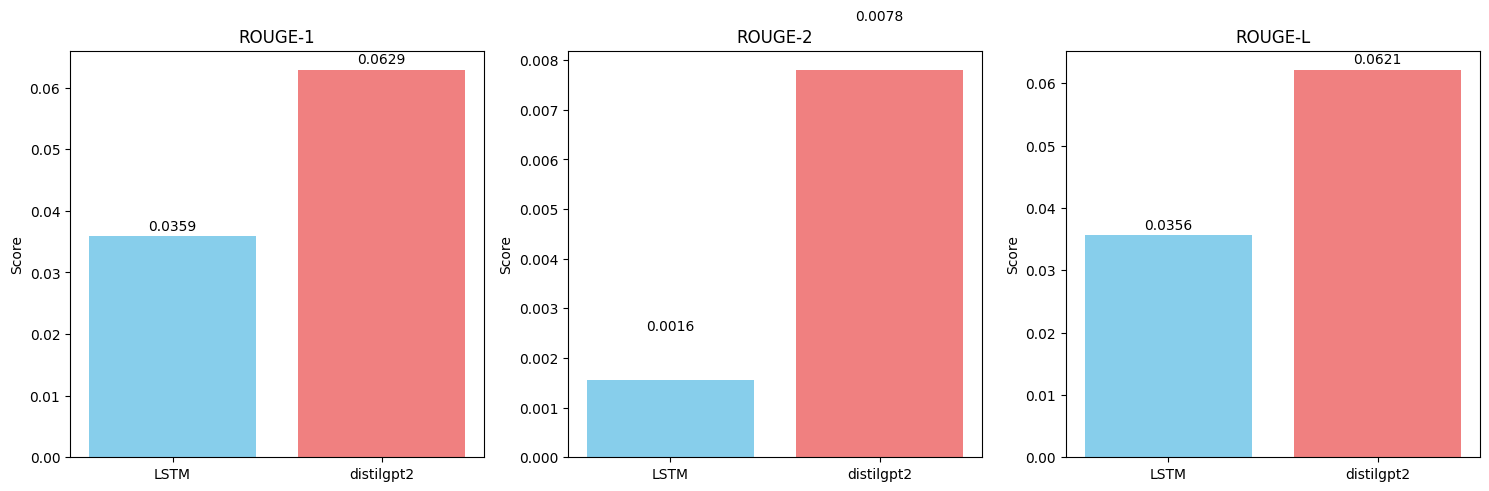

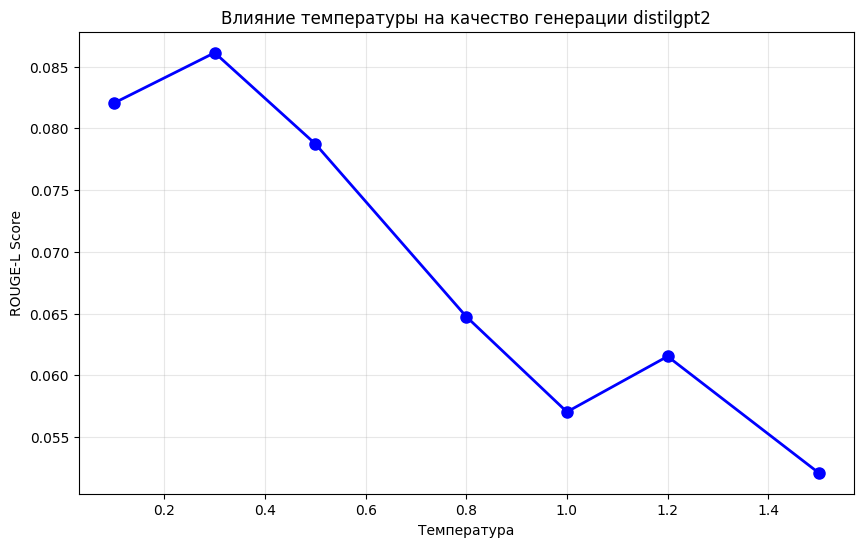

In [46]:
# –ì—Ä–∞—Ñ–∏–∫ —Å—Ä–∞–≤–Ω–µ–Ω–∏—è ROUGE –º–µ—Ç—Ä–∏–∫
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = ['LSTM', 'distilgpt2']
rouge1_scores = [lstm_rouge1, final_rouge1]
rouge2_scores = [lstm_rouge2, final_rouge2]
rougeL_scores = [lstm_rouge_l, final_rouge_l]

axes[0].bar(models, rouge1_scores, color=['skyblue', 'lightcoral'])
axes[0].set_title('ROUGE-1')
axes[0].set_ylabel('Score')
for i, v in enumerate(rouge1_scores):
    axes[0].text(i, v + 0.001, f'{v:.4f}', ha='center')

axes[1].bar(models, rouge2_scores, color=['skyblue', 'lightcoral'])
axes[1].set_title('ROUGE-2')
axes[1].set_ylabel('Score')
for i, v in enumerate(rouge2_scores):
    axes[1].text(i, v + 0.001, f'{v:.4f}', ha='center')

axes[2].bar(models, rougeL_scores, color=['skyblue', 'lightcoral'])
axes[2].set_title('ROUGE-L')
axes[2].set_ylabel('Score')
for i, v in enumerate(rougeL_scores):
    axes[2].text(i, v + 0.001, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

# –ì—Ä–∞—Ñ–∏–∫ –≤–ª–∏—è–Ω–∏—è —Ç–µ–º–ø–µ—Ä–∞—Ç—É—Ä—ã
plt.figure(figsize=(10, 6))
temps = [r['temperature'] for r in temp_results]
scores = [r['rouge_l'] for r in temp_results]
plt.plot(temps, scores, 'bo-', linewidth=2, markersize=8)
plt.xlabel('–¢–µ–º–ø–µ—Ä–∞—Ç—É—Ä–∞')
plt.ylabel('ROUGE-L Score')
plt.title('–í–ª–∏—è–Ω–∏–µ —Ç–µ–º–ø–µ—Ä–∞—Ç—É—Ä—ã –Ω–∞ –∫–∞—á–µ—Å—Ç–≤–æ –≥–µ–Ω–µ—Ä–∞—Ü–∏–∏ distilgpt2')
plt.grid(True, alpha=0.3)
plt.show()